In [64]:
import numpy as np
import pandas as pd
import plotly.express as px
import holidays
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler

# STL 분해를 위한 import 추가
try:
    from statsmodels.tsa.seasonal import STL
except ImportError:
    print("⚠️ STL을 위한 statsmodels가 설치되지 않았습니다. pip install statsmodels를 실행하세요.")
    STL = None

from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

In [71]:
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
#열이름빼기
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
#Unnamed:0제거
df_train = df_train.drop(columns=["Unnamed: 0"])
#test데이터 열이름 바꾸기
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"]

df_train = df_train[df_train['branch_id'] == 'B'].copy()
df_test = df_test[df_test['branch_id'] == 'B'].copy()

def create_time_series_features(df, target_cols=['ta', 'ws'], freq_hours=23):  # 24→23, hm→ws
    """시계열 분해를 통한 특성 생성 (STL 분해만 사용)"""
    print(f"🔄 STL 시계열 분해 특성 생성 중... (대상: {target_cols})")
    print("=" * 60)
    print("⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.")
    
    df_features = df.copy()
    
    # 브랜치별로 시계열 분해 수행
    for branch in tqdm(sorted(df['branch_id'].unique()), desc="브랜치별 STL 분해"):
        branch_mask = df_features['branch_id'] == branch
        branch_data = df_features[branch_mask].copy().sort_values('tm')
        
        if len(branch_data) < freq_hours * 7:  # 최소 7일 데이터 필요
            print(f"   ⚠️ 브랜치 {branch}: 데이터 부족 ({len(branch_data)}개) - 건너뜀")
            continue
        
        # 각 대상 변수별로 STL 분해 수행
        for col in target_cols:
            if col not in branch_data.columns:
                continue
                
            try:
                # 결측치 처리
                col_data = branch_data[col].interpolate().fillna(method='bfill').fillna(method='ffill')
                
                # STL 분해 (24시간 주기)
                try:
                    # 시간 인덱스 설정
                    ts_data = col_data.copy()
                    ts_data.index = pd.to_datetime(branch_data['tm'])
                    
                    # STL 분해
                    stl = STL(ts_data, seasonal=freq_hours, robust=True)
                    stl_result = stl.fit()
                    
                    # STL 결과 저장
                    indices = branch_data.index
                    df_features.loc[indices, f'{col}_stl_trend'] = stl_result.trend.values
                    df_features.loc[indices, f'{col}_stl_seasonal'] = stl_result.seasonal.values
                    df_features.loc[indices, f'{col}_stl_resid'] = stl_result.resid.values
                    
                    # 추가 파생 변수
                    df_features.loc[indices, f'{col}_detrend'] = col_data.values - stl_result.trend.values
                    df_features.loc[indices, f'{col}_seasonal_strength'] = np.abs(stl_result.seasonal.values)
                    
                    # 계절성 변동 지표
                    seasonal_std = np.std(stl_result.seasonal.values)
                    df_features.loc[indices, f'{col}_seasonal_volatility'] = seasonal_std
                    
                except Exception as e:
                    print(f"      ⚠️ STL 분해 실패 ({col}): {str(e)[:50]}")
                    continue
                
            except Exception as e:
                print(f"   ❌ 브랜치 {branch} {col} 분해 실패: {str(e)[:50]}")
                continue
    
    # 생성된 시계열 특성 목록
    time_series_features = [col for col in df_features.columns 
                           if any(pattern in col for pattern in ['_stl_', '_detrend', '_seasonal_strength', '_seasonal_volatility'])]
    
    print(f"\n✅ STL 시계열 분해 완료!")
    print(f"📊 생성된 시계열 특성: {len(time_series_features)}개")
    print(f"📋 특성 목록: {time_series_features[:10]}{'...' if len(time_series_features) > 10 else ''}")
    
    return df_features, time_series_features


def calculate_summer_apparent_temp(ta, hm):
    """여름철 체감온도 계산"""
    try:
        tw = ta * np.arctan(0.151977 * np.sqrt(hm + 8.313659)) \
             + np.arctan(ta + hm) \
             - np.arctan(hm - 1.676331) \
             + 0.00391838 * hm**1.5 * np.arctan(0.023101 * hm) \
             - 4.686035
        return -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    except:
        return np.nan

def calculate_winter_apparent_temp(ta, ws):
    """겨울철 체감온도 계산"""
    try:
        v = ws * 3.6  # m/s → km/h
        return 13.12 + 0.6215 * ta - 11.37 * v**0.16 + 0.3965 * ta * v**0.16
    except:
        return np.nan

def add_apparent_temp_features(df):
    df['month'] = df['tm'].dt.month
    df['apparent_temp'] = df.apply(lambda row:
        calculate_summer_apparent_temp(row['ta'], row['hm']) if 5 <= row['month'] <= 9
        else calculate_winter_apparent_temp(row['ta'], row['ws']),
        axis=1
    )
    return df


def branchwise_svr_impute(df, col, time_col='tm'):
    df = df.copy()
    # 시간 컬럼을 숫자형으로 변환 (timestamp, 초 단위)
    df['_time_num'] = pd.to_datetime(df[time_col]).astype(np.int64) // 10**9
    # branch별로 SVR 보간
    def impute_group(g):
        return svr_impute_series(g[col], g['_time_num'])
    # apply 결과를 원래 인덱스에 맞게 할당
    df[col] = df.groupby('branch_id', group_keys=False).apply(impute_group)
    df = df.drop(columns=['_time_num'])
    return df


def preprocess_weather_data(df):
    # 날짜 변환
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    # 1. si: 08~18시가 아닐 때 -99는 0으로
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0

    # 2. wd에서 9.9는 NaN으로
    df['wd'] = df['wd'].replace(9.9, np.nan)

    # 3. -99 처리
    df.replace(-99, np.nan, inplace=True)


    # SVR 보간
    df = df.sort_values(['branch_id', 'tm'])

    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()

        # 시간 특성 생성
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month

        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()

                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask

                    # 예측할 데이터 준비
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values

                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()

                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)

                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        # 보간 결과 반영
                        df.loc[branch_mask & missing_mask, col] = y_pred

                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')

                # 남은 결측 ffill/bfill로 제거
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')

        print("✅")

    print("🎉 SVR 보간 완료 (조건 없이 전부 시도)")
    #보간후 음수나올 가능성존재
    df.loc[df['ta'] < 0, 'ta'] = 0
    df.loc[df['ws'] < 0, 'ws'] = 0

    # 📌 파생 변수 생성
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['hour'] = df['tm'].dt.hour
    df['date'] = df['tm'].dt.date
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

    # 🇰🇷 한국 공휴일
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['tm'].dt.date.apply(lambda x: int(x in kr_holidays))

    # 🕒 시간 지연
    for lag in [1, 2, 3]:
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')['ta'].shift(lag)
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')[f'ta_lag_{lag}'].transform(
        lambda x: x.fillna(method='bfill'))
    # 🔥 HDD / CDD
    df['HDD18'] = np.maximum(0, 18 - df['ta'])
    #df['CDD18'] = np.maximum(0, df['ta'] - 18)
    df['HDD20'] = np.maximum(0, 20 - df['ta'])
    #df['CDD20'] = np.maximum(0, df['ta'] - 20)

    df['ws_diff_6h'] = df.groupby('branch_id')['ws'].transform(lambda x: x.diff(6).bfill())
    df['ws_diff_12h'] = df.groupby('branch_id')['ws'].transform(lambda x: x.diff(12).bfill())
    df['ws_diff_24h'] = df.groupby('branch_id')['ws'].transform(lambda x: x.diff(24).bfill())



    #직접만든 체감온도
    df = add_apparent_temp_features(df)


    # 지점별 온도 편차
    branch_mean = df.groupby('branch_id')['ta'].transform('mean')
    df['branch_temp_abs_deviation'] = np.abs(df['ta'] - branch_mean)



    # 이동 평균 (3시간 단위 최대 24시간 = 8개)
    for n in [3, 6, 9, 12, 15, 18, 21, 24]:
        df[f'ta_3h_avg_{n}'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(n, min_periods=1).mean())

    # 불쾌지수
    df['DCI'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3

    # 풍속 냉지수 (wchi)
    ws_kmh = df['ws'] * 3.6  # m/s -> km/h 변환
    df['wchi'] = 13.12 + 0.6215 * df['ta'] - 11.37 * ws_kmh**0.16 + 0.3965 * df['ta'] * ws_kmh**0.16

     # 풍속 고려 체감온도 (wind chill)
    df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * df['ws']**0.16 + 0.3965 * df['ta'] * df['ws']**0.16

    # 실효온도
    df['e'] = (df['hm'] / 100) * 6.105 * np.exp((17.27 * df['ta']) / (237.7 + df['ta']))
    df['atemphi'] = df['ta'] + 0.33 * df['e'] - 0.70 * df['ws'] - 4.00

    # 주기성 인코딩
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['dayofmonth'] = df['tm'].dt.day
    df['weekofyear'] = df['tm'].dt.isocalendar().week.astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    # 하루 5구간
    def time_slot(h): return int(h // 5)
    df['hour_slot_5'] = df['hour'].apply(time_slot)


    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        s = pd.Series(fft_vals[:n], index=pd.Index([f'fft_{i}' for i in range(n)], name='fft_idx'))
        return s

    fft_cols = ['ta', 'hm', 'ws', 'ta_chi', 'apparent_temp']
    fft_features = []
    branch_ids = df['branch_id'].unique()
    fft_feature_dict = {bid: {} for bid in branch_ids}
    for col in fft_cols:
        if col not in df.columns:
            continue
        for branch_id in branch_ids:
            arr = df.loc[df['branch_id'] == branch_id, col].fillna(0).values
            fft_vals = np.abs(fft(arr))[:10]
            for i, val in enumerate(fft_vals):
                fft_feature_dict[branch_id][f'Nph_{col}_{i}'] = val
                
    # DataFrame으로 변환
    fft_features_df = pd.DataFrame.from_dict(fft_feature_dict, orient='index')
    # 원본 df와 merge
    df = df.merge(fft_features_df, left_on='branch_id', right_index=True, how='left')

    # 기온 차분
    df['ta_diff_6h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.diff(6).bfill())
    df['ta_diff_12h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.diff(12).bfill())
    df['ta_diff_24h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.diff(24).bfill())


    # 일교차
    df['day_ta_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('max')
    df['day_ta_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('min')
    df['daily_range'] = df['day_ta_max'] - df['day_ta_min']

    # 일교차 변화량
    df['daily_range_shift'] = df.groupby('branch_id')['daily_range'].shift(1).bfill()
    df['daily_range_shift_ta'] = df['daily_range_shift']*df['ta']

    #ws변화량
    df['day_ws_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ws'].transform('max')
    df['day_ws_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ws'].transform('min')
    df['daily_range_ws'] = df['day_ws_max'] - df['day_ws_min']

    # 일교차 변화량
    df['daily_range_shift_ws'] = df.groupby('branch_id')['daily_range_ws'].shift(1).bfill()

    # 피크타임1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4

    # 피크타임2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1




    # heating season
    df['heating_season'] = df['month'].isin([10,11,12,1, 2, 3,4]).astype(int)

    # 온도 범주화
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])

    # 오전/오후
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # 계절
    def get_season(month):
        return {
            12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'fall', 10: 'fall', 11: 'fall'
        }.get(month, 'unknown')
    df['season'] = df['month'].apply(get_season)

    # 한파 주의보/경보
    df['cold_watch'] = (df['ta'] <= -12).astype(int)  # 주의보
    df['cold_warning'] = (df['ta'] <= -15).astype(int)  # 경보
    # 시계열 분해 특성 생성 (heat_demand 제외)
    print("🚀 STL 시계열 분해 시작...")
    df, ts_features = create_time_series_features(df, target_cols=['ta', 'ws'])


    # 변환 대상 변수
    col = 'ta'
    '''
    df['ta_boxcox'] = np.nan
    df['ta_boxcox_lambda'] = np.nan
    df['ta_boxcox_shift'] = np.nan  # shift 값도 저장
    for branch, group in df.groupby('branch_id'):
        col = 'ta'
        min_val = group[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1e-4
        else:
            shift = 0
        shifted = group[col] + shift
        shifted = shifted.dropna()
        if shifted.nunique() > 1 and len(shifted) >= 2:
            transformed, fitted_lambda = boxcox(shifted)
            df.loc[shifted.index, 'ta_boxcox'] = transformed
            df.loc[shifted.index, 'ta_boxcox_lambda'] = fitted_lambda
            df.loc[shifted.index, 'ta_boxcox_shift'] = shift
        else:
            df.loc[group.index, 'ta_boxcox'] = np.nan
            df.loc[group.index, 'ta_boxcox_lambda'] = np.nan
            df.loc[group.index, 'ta_boxcox_shift'] = shift


    '''
    df = df.drop(columns=['date'])
    # 파생변수 3개 추가
    df['ta_ws'] = df['ta'] * df['ws']

    df['ws_abs_diff_1h'] = df['ws'].diff(1).abs().bfill()

    df['ws_jump_flag'] = (df['ws'] > df['ws'].shift(1) * 2).astype(int)



    return df







#정규화 일단 min max +원핫인코딩
def scale_encode(df):
    cat_cols = [
        'peak_time1', 'peak_time2', 'heating_season','hour_slot_5',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season','month','day','hour']

    # 범주형 변수 category화
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 연속형 변수만 추출 (타겟, 날짜 등 제외)
    exclude_cols = ['heat_demand','peak_time1', 'peak_time2', 'heating_season','hour_slot_5',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season','month','day','hour']
    num_cols = [col for col in df.columns
                if (df[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

    # MinMaxScaler 적용
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    


    return df



df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)


#변수좀제거
def remove_highly_correlated_features(df, target_col='heat_demand', threshold=0.95):
    # 타겟, 날짜 등 제외
    exclude_cols = [target_col]
    num_cols = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and col not in exclude_cols]
    corr_matrix = df[num_cols].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"상관계수 {threshold} 이상인 변수 {len(to_drop)}개 제거: {to_drop}")
    df = df.drop(columns=to_drop)
    return df, to_drop
df_train, dropped_cols = remove_highly_correlated_features(df_train, target_col='heat_demand', threshold=0.95)
df_test = df_test.drop(columns=[col for col in dropped_cols if col in df_test.columns])






df_train = scale_encode(df_train)
df_test = scale_encode(df_test)

df_train.to_csv('df_train_prescale.csv', index=True)
df_test.to_csv('df_test_prescale.csv', index=True)

   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
🚀 STL 시계열 분해 시작...
🔄 STL 시계열 분해 특성 생성 중... (대상: ['ta', 'ws'])
⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.


브랜치별 STL 분해: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s]

      ⚠️ STL 분해 실패 (ta): name 'STL' is not defined
      ⚠️ STL 분해 실패 (ws): name 'STL' is not defined

✅ STL 시계열 분해 완료!
📊 생성된 시계열 특성: 0개
📋 특성 목록: []
   🏢 브랜치 B SVR 보간 중... 


   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
🚀 STL 시계열 분해 시작...
🔄 STL 시계열 분해 특성 생성 중... (대상: ['ta', 'ws'])
⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.


브랜치별 STL 분해: 100%|██████████| 1/1 [00:00<00:00, 76.44it/s]

      ⚠️ STL 분해 실패 (ta): name 'STL' is not defined
      ⚠️ STL 분해 실패 (ws): name 'STL' is not defined

✅ STL 시계열 분해 완료!
📊 생성된 시계열 특성: 0개
📋 특성 목록: []


상관계수 0.95 이상인 변수 25개 제거: ['ta_chi', 'ta_lag_1', 'ta_lag_2', 'ta_lag_3', 'HDD18', 'HDD20', 'apparent_temp', 'ta_3h_avg_3', 'ta_3h_avg_6', 'ta_3h_avg_9', 'ta_3h_avg_12', 'ta_3h_avg_15', 'ta_3h_avg_18', 'ta_3h_avg_21', 'ta_3h_avg_24', 'DCI', 'wchi', 'wind_chill', 'atemphi', 'month_sin', 'day_ta_max', 'day_ta_min', 'daily_range_shift', 'daily_range_ws', 'daily_range_shift_ws']


In [72]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['year'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [75]:
from sklearn.model_selection import TimeSeriesSplit

def run_5fold_pipeline_with_residual(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]
    X = df_train[features]
    y = df_train[target_col]

    tscv = TimeSeriesSplit(n_splits=5)
    val_rmses = []
    test_preds = []

    print(f"전체 데이터 길이: {len(df_train)}, Fold 수: 5\n")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        print(f"===== Fold {fold+1} =====")
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

        # 이하 LightGBM/XGBoost 최적화 및 학습 코드는 동일하게 사용
        # ... (아래는 기존 코드와 동일하게 복사/붙여넣기)
        # 1) LightGBM 베이지안 최적화 함수
        def lgb_objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, val_pred))

        lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        lgb_study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)

        best_lgb_params = lgb_study.best_params
        best_lgb_params.update({
            'objective': 'huber',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        lgb_model = lgb.LGBMRegressor(**best_lgb_params)
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
        )

        val_pred_lgb = lgb_model.predict(X_val)
        val_rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
        print(f"LightGBM Fold {fold+1} Validation RMSE: {val_rmse_lgb:.4f}")

        residual_train = y_train - lgb_model.predict(X_train)
        residual_val = y_val - val_pred_lgb

        def xgb_objective(trial):
            params = {
                'objective': 'reg:pseudohubererror',
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 2, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': 42,
                'n_jobs': -1
            }
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train, residual_train,
                eval_set=[(X_val, residual_val)],
                verbose=0
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(residual_val, val_pred))

        xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

        best_xgb_params = xgb_study.best_params
        best_xgb_params.update({
            'objective': 'reg:pseudohubererror',
            'random_state': 42,
            'n_jobs': -1
        })

        xgb_model = xgb.XGBRegressor(**best_xgb_params)
        xgb_model.fit(
            X_train, residual_train,
            eval_set=[(X_val, residual_val)],
            verbose=100
        )

        val_pred_residual = xgb_model.predict(X_val)
        val_pred_final = val_pred_lgb + val_pred_residual
        val_rmse_final = np.sqrt(mean_squared_error(y_val, val_pred_final))
        print(f"Residual Stacking Fold {fold+1} Validation RMSE: {val_rmse_final:.4f}")

        val_rmses.append(val_rmse_final)

        test_pred_lgb = lgb_model.predict(df_test[features])
        test_pred_residual = xgb_model.predict(df_test[features])
        test_pred_fold = test_pred_lgb + test_pred_residual
        test_preds.append(test_pred_fold)

        print("-----------------------------")

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    print(f"\n최종 평균 Validation RMSE: {avg_val_rmse:.4f}")

    df_test[target_col] = avg_test_pred

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,
        'test_pred': avg_test_pred,
        'test_index': df_test.index
    }

[I 2025-06-23 01:08:38,850] A new study created in memory with name: no-name-ac5634b7-59a4-4779-8f67-2dd526fc8bd7


전체 데이터 길이: 17519, Fold 크기: 5839

===== Fold 1 =====
Train size: 5839, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 1. Best value: 76.4707:  10%|█         | 2/20 [00:00<00:04,  3.75it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-23 01:08:39,291] Trial 0 finished with value: 93.49869698559274 and parameters: {'learning_rate': 0.03574712922600244, 'num_leaves': 286, 'max_depth': 12, 'min_data_in_leaf': 124, 'feature_fraction': 0.4936111842654619, 'bagging_fraction': 0.49359671220172163, 'bagging_freq': 1, 'reg_alpha': 8.661761457749352, 'reg_lambda': 6.011150117432088}. Best is trial 0 with value: 93.49869698559274.
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_s

Best trial: 1. Best value: 76.4707:  15%|█▌        | 3/20 [00:00<00:04,  3.54it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[88]	valid_0's rmse: 121.781
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.5752867891211308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5752867891211308
[LightGBM] [Warning] bagging_fraction is set=0.619817105976215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.619817105976215
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will

Best trial: 1. Best value: 76.4707:  25%|██▌       | 5/20 [00:01<00:03,  4.40it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 76.4707:  30%|███       | 6/20 [00:01<00:03,  4.07it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 76.4707:  35%|███▌      | 7/20 [00:01<00:02,  4.61it/s]

[I 2025-06-23 01:08:40,548] Trial 6 finished with value: 98.48551203269936 and parameters: {'learning_rate': 0.0764136186923332, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.4271363733463229, 'bagging_fraction': 0.5951981984579586, 'bagging_freq': 3, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 1 with value: 76.47071559466674.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.8813181884524238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8813181884524238
[LightGBM] [Warning] bagging_fraction is set=0.44473038620786254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44473038620786254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=

Best trial: 1. Best value: 76.4707:  40%|████      | 8/20 [00:02<00:03,  3.55it/s]

[I 2025-06-23 01:08:40,984] Trial 7 finished with value: 144.45568938704955 and parameters: {'learning_rate': 0.03364867144187954, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.8813181884524238, 'bagging_fraction': 0.44473038620786254, 'bagging_freq': 7, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 1 with value: 76.47071559466674.
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_sa

Best trial: 1. Best value: 76.4707:  50%|█████     | 10/20 [00:02<00:02,  3.83it/s]

[I 2025-06-23 01:08:41,401] Trial 8 finished with value: 132.45849794723426 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 1 with value: 76.47071559466674.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_sam

Best trial: 1. Best value: 76.4707:  60%|██████    | 12/20 [00:02<00:01,  4.89it/s]

Early stopping, best iteration is:
[15]	valid_0's rmse: 133.084
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] feature_fraction is set=0.7274309680493293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7274309680493293
[LightGBM] [Warning] bagging_fraction is set=0.8141482441414871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141482441414871
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-23 01:08:41,674] Trial 10 finished with value: 133.08447846662634 and parameters: {'learning_rate': 0.26900591974735844, 'num_leaves': 11, 'max_depth': 15, 'min_data_in_leaf': 191, 'feature_fraction': 0.7274309680493293, 'bagging_fraction': 0.8141482441414871, 'bagging_freq': 2, 'reg_alpha': 4.040260720186448, 'reg_lambda': 4.792951727359478}. Best is trial 1 with value: 76.47071559466674.

Best trial: 1. Best value: 76.4707:  65%|██████▌   | 13/20 [00:03<00:01,  5.29it/s]

[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] feature_fraction is set=0.7021863590894724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021863590894724
[LightGBM] [Warning] bagging_fraction is set=0.42929971649028187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42929971649028187
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] feature_fraction is set=0.7021863590894724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7021863590894724
[LightGBM] [Warning] bagging_fraction is set=0.42929971649028187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42929971649028187
[LightGBM] [Warning] bagging_freq is s

Best trial: 1. Best value: 76.4707:  75%|███████▌  | 15/20 [00:03<00:00,  6.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 76.4707:  80%|████████  | 16/20 [00:03<00:00,  6.07it/s]

[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] feature_fraction is set=0.6482067231349912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6482067231349912
[LightGBM] [Warning] bagging_fraction is set=0.5214928759168733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5214928759168733
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=145, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=145
[LightGBM] [Warning] feature_fraction is set=0.6482067231349912, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6482067231349912
[LightGBM] [Warning] bagging_fraction is set=0.5214928759168733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5214928759168733
[LightGBM] [Warning] bagging_freq is set=3

Best trial: 1. Best value: 76.4707:  85%|████████▌ | 17/20 [00:03<00:00,  5.93it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 76.4707:  90%|█████████ | 18/20 [00:04<00:00,  4.65it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 1. Best value: 76.4707:  95%|█████████▌| 19/20 [00:04<00:00,  5.09it/s]

[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.4127696105746338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4127696105746338
[LightGBM] [Warning] bagging_fraction is set=0.6094623803975802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094623803975802
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=150
[LightGBM] [Warning] feature_fraction is set=0.4127696105746338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4127696105746338
[LightGBM] [Warning] bagging_fraction is set=0.6094623803975802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094623803975802
[LightGBM] [Warning] bagging_freq is set=2

Best trial: 1. Best value: 76.4707: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 212.027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-06-23 01:08:43,859] A new study created in memory with name: no-name-b5d52b14-59cf-4ee8-8001-c09c67994b05


LightGBM Fold 1 Validation RMSE: 180.8969
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


Best trial: 0. Best value: 141.959:   5%|▌         | 1/20 [00:01<00:37,  1.97s/it]

[I 2025-06-23 01:08:45,834] Trial 0 finished with value: 141.95933385833766 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 141.95933385833766.


Best trial: 1. Best value: 122.34:  10%|█         | 2/20 [00:05<00:54,  3.01s/it] 

[I 2025-06-23 01:08:49,562] Trial 1 finished with value: 122.34038357724425 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 122.34038357724425.


Best trial: 2. Best value: 119.327:  15%|█▌        | 3/20 [00:06<00:32,  1.92s/it]

[I 2025-06-23 01:08:50,187] Trial 2 finished with value: 119.32705027894038 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 2 with value: 119.32705027894038.


Best trial: 2. Best value: 119.327:  20%|██        | 4/20 [00:06<00:22,  1.41s/it]

[I 2025-06-23 01:08:50,823] Trial 3 finished with value: 119.32944954428473 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 2 with value: 119.32705027894038.


Best trial: 4. Best value: 113.363:  25%|██▌       | 5/20 [00:09<00:25,  1.72s/it]

[I 2025-06-23 01:08:53,079] Trial 4 finished with value: 113.36349296292593 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 4 with value: 113.36349296292593.


Best trial: 4. Best value: 113.363:  30%|███       | 6/20 [00:11<00:27,  1.94s/it]

[I 2025-06-23 01:08:55,439] Trial 5 finished with value: 115.82837158253155 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 4 with value: 113.36349296292593.


Best trial: 4. Best value: 113.363:  35%|███▌      | 7/20 [00:12<00:19,  1.46s/it]

[I 2025-06-23 01:08:55,927] Trial 6 finished with value: 115.68218667036986 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 4 with value: 113.36349296292593.


Best trial: 4. Best value: 113.363:  40%|████      | 8/20 [00:14<00:19,  1.65s/it]

[I 2025-06-23 01:08:57,976] Trial 7 finished with value: 126.47573540829436 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 4 with value: 113.36349296292593.


Best trial: 4. Best value: 113.363:  45%|████▌     | 9/20 [00:14<00:14,  1.31s/it]

[I 2025-06-23 01:08:58,544] Trial 8 finished with value: 137.73843275886102 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 4 with value: 113.36349296292593.


Best trial: 4. Best value: 113.363:  50%|█████     | 10/20 [00:16<00:14,  1.44s/it]

[I 2025-06-23 01:09:00,278] Trial 9 finished with value: 122.09603206374962 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 4 with value: 113.36349296292593.


Best trial: 10. Best value: 110.273:  55%|█████▌    | 11/20 [00:20<00:19,  2.22s/it]

[I 2025-06-23 01:09:04,263] Trial 10 finished with value: 110.2732803196728 and parameters: {'n_estimators': 675, 'learning_rate': 0.010206070557576998, 'max_depth': 10, 'subsample': 0.6248126654205948, 'colsample_bytree': 0.5072704375811822, 'reg_alpha': 9.07664795282518, 'reg_lambda': 7.3036689520700975}. Best is trial 10 with value: 110.2732803196728.


Best trial: 11. Best value: 107.989:  60%|██████    | 12/20 [00:24<00:22,  2.81s/it]

[I 2025-06-23 01:09:08,436] Trial 11 finished with value: 107.98948989708819 and parameters: {'n_estimators': 674, 'learning_rate': 0.011237584680949443, 'max_depth': 10, 'subsample': 0.6047958370714842, 'colsample_bytree': 0.5043526805991965, 'reg_alpha': 9.536235736577245, 'reg_lambda': 7.249708236172733}. Best is trial 11 with value: 107.98948989708819.


Best trial: 12. Best value: 106.674:  65%|██████▌   | 13/20 [00:29<00:23,  3.30s/it]

[I 2025-06-23 01:09:12,863] Trial 12 finished with value: 106.67434062886913 and parameters: {'n_estimators': 697, 'learning_rate': 0.010704046708553183, 'max_depth': 10, 'subsample': 0.6535780026284043, 'colsample_bytree': 0.5038833349269608, 'reg_alpha': 7.587629275065533, 'reg_lambda': 7.31824954551923}. Best is trial 12 with value: 106.67434062886913.


Best trial: 12. Best value: 106.674:  70%|███████   | 14/20 [00:35<00:26,  4.35s/it]

[I 2025-06-23 01:09:19,643] Trial 13 finished with value: 113.35835871396293 and parameters: {'n_estimators': 997, 'learning_rate': 0.04924185908787297, 'max_depth': 10, 'subsample': 0.6938506955706596, 'colsample_bytree': 0.6190172518128465, 'reg_alpha': 7.316500613968534, 'reg_lambda': 7.119778022134117}. Best is trial 12 with value: 106.67434062886913.


Best trial: 12. Best value: 106.674:  75%|███████▌  | 15/20 [00:40<00:21,  4.37s/it]

[I 2025-06-23 01:09:24,054] Trial 14 finished with value: 117.81700590786222 and parameters: {'n_estimators': 686, 'learning_rate': 0.05763333406956571, 'max_depth': 10, 'subsample': 0.5043792757407254, 'colsample_bytree': 0.8095839387020463, 'reg_alpha': 7.198007310001181, 'reg_lambda': 3.590839457281545}. Best is trial 12 with value: 106.67434062886913.


Best trial: 12. Best value: 106.674:  80%|████████  | 16/20 [00:43<00:16,  4.07s/it]

[I 2025-06-23 01:09:27,440] Trial 15 finished with value: 110.2096359648166 and parameters: {'n_estimators': 515, 'learning_rate': 0.01548777445311471, 'max_depth': 9, 'subsample': 0.6482722705221974, 'colsample_bytree': 0.5652307081641357, 'reg_alpha': 9.986415310189631, 'reg_lambda': 7.516134248157892}. Best is trial 12 with value: 106.67434062886913.


Best trial: 12. Best value: 106.674:  85%|████████▌ | 17/20 [00:48<00:13,  4.47s/it]

[I 2025-06-23 01:09:32,815] Trial 16 finished with value: 116.11397981280557 and parameters: {'n_estimators': 790, 'learning_rate': 0.12782552908348466, 'max_depth': 9, 'subsample': 0.5809860205568331, 'colsample_bytree': 0.7947992509228796, 'reg_alpha': 7.6147613292925795, 'reg_lambda': 3.739777057415845}. Best is trial 12 with value: 106.67434062886913.


Best trial: 12. Best value: 106.674:  90%|█████████ | 18/20 [00:52<00:08,  4.23s/it]

[I 2025-06-23 01:09:36,509] Trial 17 finished with value: 114.54909573161868 and parameters: {'n_estimators': 567, 'learning_rate': 0.04032506326820708, 'max_depth': 9, 'subsample': 0.913217399679865, 'colsample_bytree': 0.6100901161384537, 'reg_alpha': 6.216169773911954, 'reg_lambda': 8.27787259457541}. Best is trial 12 with value: 106.67434062886913.


Best trial: 18. Best value: 105.705:  95%|█████████▌| 19/20 [00:55<00:03,  3.96s/it]

[I 2025-06-23 01:09:39,822] Trial 18 finished with value: 105.704683915261 and parameters: {'n_estimators': 732, 'learning_rate': 0.010089537012057318, 'max_depth': 7, 'subsample': 0.6936901560719675, 'colsample_bytree': 0.5002367083943663, 'reg_alpha': 3.8876919478638627, 'reg_lambda': 6.342941570142694}. Best is trial 18 with value: 105.704683915261.


Best trial: 19. Best value: 105.282: 100%|██████████| 20/20 [00:59<00:00,  2.99s/it]

[I 2025-06-23 01:09:43,671] Trial 19 finished with value: 105.28160625312206 and parameters: {'n_estimators': 948, 'learning_rate': 0.016423823012392237, 'max_depth': 6, 'subsample': 0.7178092877156979, 'colsample_bytree': 0.5621742551169755, 'reg_alpha': 3.8018272638611075, 'reg_lambda': 6.215775530383457}. Best is trial 19 with value: 105.28160625312206.
[0]	validation_0-mphe:139.70676


[100]	validation_0-mphe:100.07175
[200]	validation_0-mphe:83.31127
[300]	validation_0-mphe:75.62126
[400]	validation_0-mphe:72.59881
[500]	validation_0-mphe:70.86398
[600]	validation_0-mphe:70.27131
[700]	validation_0-mphe:69.86842
[800]	validation_0-mphe:70.00515
[900]	validation_0-mphe:70.11663
[947]	validation_0-mphe:70.17996
Residual Stacking Fold 1 Validation RMSE: 105.2816
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2025-06-23 01:09:48,423] A new study created in memory with name: no-name-7b2d9581-1323-4066-a87b-64367d259e37


-----------------------------
===== Fold 2 =====
Train size: 11678, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 29.7292:   5%|▌         | 1/20 [00:00<00:14,  1.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.7292:  10%|█         | 2/20 [00:01<00:08,  2.13it/s]

Early stopping, best iteration is:
[80]	valid_0's rmse: 30.5735
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-23 01:09:49,443] Trial 1 finished with value: 30.57348425802395 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 29.72918864643005.


Best trial: 0. Best value: 29.7292:  15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[97]	valid_0's rmse: 30.9467
[LightGBM] [Warning] min_data_in_lea

Best trial: 0. Best value: 29.7292:  20%|██        | 4/20 [00:01<00:06,  2.32it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.7292:  25%|██▌       | 5/20 [00:02<00:07,  1.91it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.7292:  30%|███       | 6/20 [00:02<00:06,  2.17it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.7292:  35%|███▌      | 7/20 [00:03<00:05,  2.35it/s]

[I 2025-06-23 01:09:51,710] Trial 6 finished with value: 31.56083953184301 and parameters: {'learning_rate': 0.0764136186923332, 'num_leaves': 278, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.4271363733463229, 'bagging_fraction': 0.5951981984579586, 'bagging_freq': 3, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 0 with value: 29.72918864643005.
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.8813181884524238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8813181884524238
[LightGBM] [Warning] bagging_fraction is set=0.44473038620786254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44473038620786254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=

Best trial: 0. Best value: 29.7292:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

[I 2025-06-23 01:09:52,585] Trial 7 finished with value: 31.438949406982367 and parameters: {'learning_rate': 0.03364867144187954, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.8813181884524238, 'bagging_fraction': 0.44473038620786254, 'bagging_freq': 7, 'reg_alpha': 7.722447692966574, 'reg_lambda': 1.987156815341724}. Best is trial 0 with value: 29.72918864643005.
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=149
[LightGBM] [Warning] feature_fraction is set=0.8627622080115674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8627622080115674
[LightGBM] [Warning] bagging_fraction is set=0.44442679104045424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44442679104045424
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=149, min_child_sa

Best trial: 0. Best value: 29.7292:  45%|████▌     | 9/20 [00:06<00:10,  1.00it/s]

[I 2025-06-23 01:09:54,522] Trial 8 finished with value: 30.33095253397944 and parameters: {'learning_rate': 0.010189592979395137, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 149, 'feature_fraction': 0.8627622080115674, 'bagging_fraction': 0.44442679104045424, 'bagging_freq': 3, 'reg_alpha': 1.1586905952512971, 'reg_lambda': 8.631034258755935}. Best is trial 0 with value: 29.72918864643005.
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samp

Best trial: 0. Best value: 29.7292:  50%|█████     | 10/20 [00:06<00:07,  1.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.7292:  55%|█████▌    | 11/20 [00:06<00:05,  1.58it/s]

[LightGBM] [Info] Number of data points in the train set: 11678, number of used features: 113
[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7128040071176207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128040071176207
[LightGBM] [Warning] bagging_fraction is set=0.8141482441414871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141482441414871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Start training from score 269.930724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

Best trial: 0. Best value: 29.7292:  60%|██████    | 12/20 [00:07<00:05,  1.47it/s]

Early stopping, best iteration is:
[448]	valid_0's rmse: 31.0435
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.6848388465895692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848388465895692
[LightGBM] [Warning] bagging_fraction is set=0.7339015268508008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339015268508008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-23 01:09:55,905] Trial 11 finished with value: 31.04349655540552 and parameters: {'learning_rate': 0.020994760104036503, 'num_leaves': 14, 'max_depth': 13, 'min_data_in_leaf': 85, 'feature_fraction': 0.6848388465895692, 'bagging_fraction': 0.7339015268508008, 'bagging_freq': 1, 'reg_alpha': 5.732909776512292, 'reg_lambda': 0.11613085798786882}. Best is trial 0 with value: 29.72918864643005.

Best trial: 0. Best value: 29.7292:  65%|██████▌   | 13/20 [00:08<00:05,  1.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 29.2814:  70%|███████   | 14/20 [00:10<00:06,  1.00s/it]

[I 2025-06-23 01:09:58,428] Trial 13 finished with value: 29.28142602838591 and parameters: {'learning_rate': 0.015316484348685525, 'num_leaves': 295, 'max_depth': 14, 'min_data_in_leaf': 126, 'feature_fraction': 0.4015540311493189, 'bagging_fraction': 0.5584343119626605, 'bagging_freq': 2, 'reg_alpha': 7.11487014864477, 'reg_lambda': 6.569779332267137}. Best is trial 13 with value: 29.28142602838591.
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=136
[LightGBM] [Warning] feature_fraction is set=0.6758022628419735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758022628419735
[LightGBM] [Warning] bagging_fraction is set=0.5409428474348138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5409428474348138
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=136, min_child_sa

Best trial: 13. Best value: 29.2814:  75%|███████▌  | 15/20 [00:11<00:06,  1.21s/it]

[I 2025-06-23 01:10:00,107] Trial 14 finished with value: 29.91494981657784 and parameters: {'learning_rate': 0.010457065772553623, 'num_leaves': 290, 'max_depth': 15, 'min_data_in_leaf': 136, 'feature_fraction': 0.6758022628419735, 'bagging_fraction': 0.5409428474348138, 'bagging_freq': 3, 'reg_alpha': 3.999806993837149, 'reg_lambda': 6.549657788381967}. Best is trial 13 with value: 29.28142602838591.
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.5274590358130676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5274590358130676
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_s

Best trial: 15. Best value: 29.2575:  80%|████████  | 16/20 [00:13<00:05,  1.29s/it]

[I 2025-06-23 01:10:01,588] Trial 15 finished with value: 29.257480163185914 and parameters: {'learning_rate': 0.014932497240539935, 'num_leaves': 238, 'max_depth': 13, 'min_data_in_leaf': 151, 'feature_fraction': 0.4048236215996866, 'bagging_fraction': 0.5274590358130676, 'bagging_freq': 2, 'reg_alpha': 6.705451426048867, 'reg_lambda': 6.957206225405724}. Best is trial 15 with value: 29.257480163185914.
[LightGBM] [Warning] min_data_in_leaf is set=197, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=197
[LightGBM] [Warning] feature_fraction is set=0.7775971996178893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7775971996178893
[LightGBM] [Warning] bagging_fraction is set=0.6665798332295039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6665798332295039
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=197, min_child

Best trial: 15. Best value: 29.2575:  85%|████████▌ | 17/20 [00:14<00:03,  1.33s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 15. Best value: 29.2575:  90%|█████████ | 18/20 [00:15<00:02,  1.30s/it]

[LightGBM] [Warning] min_data_in_leaf is set=160, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160
[LightGBM] [Warning] feature_fraction is set=0.40649917123165874, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40649917123165874
[LightGBM] [Warning] bagging_fraction is set=0.5374636556379794, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5374636556379794
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[I 2025-06-23 01:10:04,229] Trial 17 finished with value: 29.60036902958361 and parameters: {'learning_rate': 0.015620696460990846, 'num_leaves': 237, 'max_depth': 7, 'min_data_in_leaf': 160, 'feature_fraction': 0.40649917123165874, 'bagging_fraction': 0.5374636556379794, 'bagging_freq': 4, 'reg_alpha': 7.046392758077681, 'reg_lambda': 9.93717758713888}. Best is trial 15 with value: 29.257480163185914.
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_

Best trial: 15. Best value: 29.2575:  95%|█████████▌| 19/20 [00:16<00:01,  1.13s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[28]	valid_0's rmse: 31.7086
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.5936806046355794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936806046355794
[LightGBM] [Warning] bagging_fraction is set=0.7549106025974355, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7549106025974355
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-23 01:10:04,980] Trial 18 finished with value: 31.70861332445368 and parameters: {'learning_ra

Best trial: 15. Best value: 29.2575: 100%|██████████| 20/20 [00:17<00:00,  1.13it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[681]	valid_0's rmse: 30.2767
[LightGBM] [Warning] min_data_in_leaf is set=173, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=173
[LightGBM] [Warning] feature_fraction is set=0.9261058271530125, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261058271530125
[LightGBM] [Warning] bagging_fraction is set=0.40705015392030675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40705015392030675
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[I 2025-06-23 01:10:06,092] Trial 19 finished with value: 30.276731437759196 and parameters: {'learning_rate': 0.01567816406367906, 'num_leaves': 259, 'max_depth': 8, 'min_data_in_leaf': 173, 'feature_fraction': 0.9261058271530125, 'bagging_fraction': 0.40705015392030675, 'bagging_freq': 4, 'reg_alpha': 5.465122654917218, '

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-23 01:10:07,309] A new study created in memory with name: no-name-a21a51e9-faf3-470b-9876-ca14715fec4b
Best trial: 0. Best value: 53.6624:   5%|▌         | 1/20 [00:02<00:55,  2.93s/it]

[I 2025-06-23 01:10:10,243] Trial 0 finished with value: 53.6623800103186 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 53.6623800103186.


Best trial: 1. Best value: 29.7749:  10%|█         | 2/20 [00:09<01:31,  5.06s/it]

[I 2025-06-23 01:10:16,784] Trial 1 finished with value: 29.774931029881756 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  15%|█▌        | 3/20 [00:10<00:54,  3.22s/it]

[I 2025-06-23 01:10:17,824] Trial 2 finished with value: 34.71046013887396 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  20%|██        | 4/20 [00:11<00:37,  2.36s/it]

[I 2025-06-23 01:10:18,860] Trial 3 finished with value: 32.59987835312163 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  25%|██▌       | 5/20 [00:14<00:40,  2.69s/it]

[I 2025-06-23 01:10:22,151] Trial 4 finished with value: 34.55415093261513 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  30%|███       | 6/20 [00:17<00:36,  2.62s/it]

[I 2025-06-23 01:10:24,638] Trial 5 finished with value: 31.440216685354155 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  35%|███▌      | 7/20 [00:17<00:25,  1.94s/it]

[I 2025-06-23 01:10:25,185] Trial 6 finished with value: 30.754518634112443 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  40%|████      | 8/20 [00:20<00:24,  2.04s/it]

[I 2025-06-23 01:10:27,418] Trial 7 finished with value: 31.199628031850835 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  45%|████▌     | 9/20 [00:20<00:17,  1.62s/it]

[I 2025-06-23 01:10:28,137] Trial 8 finished with value: 51.43999363665105 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  50%|█████     | 10/20 [00:23<00:18,  1.81s/it]

[I 2025-06-23 01:10:30,351] Trial 9 finished with value: 31.389404276891728 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  55%|█████▌    | 11/20 [00:33<00:39,  4.39s/it]

[I 2025-06-23 01:10:40,599] Trial 10 finished with value: 30.87791800183536 and parameters: {'n_estimators': 981, 'learning_rate': 0.09289825888463438, 'max_depth': 10, 'subsample': 0.5089809378074099, 'colsample_bytree': 0.8259332753890893, 'reg_alpha': 9.07664795282518, 'reg_lambda': 0.808876263738469}. Best is trial 1 with value: 29.774931029881756.


Best trial: 1. Best value: 29.7749:  60%|██████    | 12/20 [00:40<00:41,  5.18s/it]

[I 2025-06-23 01:10:47,584] Trial 11 finished with value: 31.79311142303581 and parameters: {'n_estimators': 674, 'learning_rate': 0.11693657276747411, 'max_depth': 10, 'subsample': 0.9153368210114128, 'colsample_bytree': 0.6294860237055974, 'reg_alpha': 6.34641002463935, 'reg_lambda': 2.922384655019864}. Best is trial 1 with value: 29.774931029881756.


Best trial: 12. Best value: 29.6245:  65%|██████▌   | 13/20 [00:43<00:32,  4.71s/it]

[I 2025-06-23 01:10:51,216] Trial 12 finished with value: 29.62448036843489 and parameters: {'n_estimators': 995, 'learning_rate': 0.06314348458287039, 'max_depth': 4, 'subsample': 0.8649245219634518, 'colsample_bytree': 0.8134854000007805, 'reg_alpha': 7.711523100977625, 'reg_lambda': 2.6465963296377906}. Best is trial 12 with value: 29.62448036843489.


Best trial: 12. Best value: 29.6245:  70%|███████   | 14/20 [00:51<00:33,  5.64s/it]

[I 2025-06-23 01:10:59,019] Trial 13 finished with value: 30.782714971447096 and parameters: {'n_estimators': 999, 'learning_rate': 0.05231199227102143, 'max_depth': 8, 'subsample': 0.9006746608746032, 'colsample_bytree': 0.9900155864470129, 'reg_alpha': 7.719295837601935, 'reg_lambda': 2.271390116508787}. Best is trial 12 with value: 29.62448036843489.


Best trial: 14. Best value: 29.0143:  75%|███████▌  | 15/20 [00:55<00:25,  5.19s/it]

[I 2025-06-23 01:11:03,152] Trial 14 finished with value: 29.014332422591803 and parameters: {'n_estimators': 826, 'learning_rate': 0.06053713630509484, 'max_depth': 4, 'subsample': 0.6634252920853465, 'colsample_bytree': 0.8095839387020463, 'reg_alpha': 7.719985379615895, 'reg_lambda': 3.1223493592211646}. Best is trial 14 with value: 29.014332422591803.


Best trial: 14. Best value: 29.0143:  80%|████████  | 16/20 [00:59<00:18,  4.58s/it]

[I 2025-06-23 01:11:06,334] Trial 15 finished with value: 29.089466833557427 and parameters: {'n_estimators': 808, 'learning_rate': 0.04806125039623625, 'max_depth': 3, 'subsample': 0.7209664431135016, 'colsample_bytree': 0.7887371339752004, 'reg_alpha': 7.130969478282992, 'reg_lambda': 4.0834091032518085}. Best is trial 14 with value: 29.014332422591803.


Best trial: 14. Best value: 29.0143:  85%|████████▌ | 17/20 [01:01<00:12,  4.07s/it]

[I 2025-06-23 01:11:09,202] Trial 16 finished with value: 29.820041166336487 and parameters: {'n_estimators': 758, 'learning_rate': 0.040574293515963374, 'max_depth': 3, 'subsample': 0.6912330051734872, 'colsample_bytree': 0.7947992509228796, 'reg_alpha': 6.812724396315809, 'reg_lambda': 3.8827067456726327}. Best is trial 14 with value: 29.014332422591803.


Best trial: 14. Best value: 29.0143:  90%|█████████ | 18/20 [01:05<00:08,  4.01s/it]

[I 2025-06-23 01:11:13,076] Trial 17 finished with value: 30.189682071718963 and parameters: {'n_estimators': 519, 'learning_rate': 0.12950048245442924, 'max_depth': 3, 'subsample': 0.6430104032327739, 'colsample_bytree': 0.7724435369990436, 'reg_alpha': 4.991997267292623, 'reg_lambda': 6.394684662708778}. Best is trial 14 with value: 29.014332422591803.


Best trial: 18. Best value: 28.8573:  95%|█████████▌| 19/20 [01:09<00:03,  3.89s/it]

[I 2025-06-23 01:11:16,695] Trial 18 finished with value: 28.857259570184777 and parameters: {'n_estimators': 751, 'learning_rate': 0.043978458139766696, 'max_depth': 5, 'subsample': 0.6152696732954291, 'colsample_bytree': 0.8642399698901131, 'reg_alpha': 4.478852818704937, 'reg_lambda': 3.723278231837623}. Best is trial 18 with value: 28.857259570184777.


Best trial: 18. Best value: 28.8573: 100%|██████████| 20/20 [01:13<00:00,  3.67s/it]

[I 2025-06-23 01:11:20,717] Trial 19 finished with value: 31.347111215742427 and parameters: {'n_estimators': 703, 'learning_rate': 0.17074545294037394, 'max_depth': 6, 'subsample': 0.6055818703021868, 'colsample_bytree': 0.8577269361926916, 'reg_alpha': 3.8871777891041397, 'reg_lambda': 3.766807649900212}. Best is trial 18 with value: 28.857259570184777.
[0]	validation_0-mphe:116.45229


[100]	validation_0-mphe:22.26311
[200]	validation_0-mphe:20.53963
[300]	validation_0-mphe:20.13762
[400]	validation_0-mphe:19.97280
[500]	validation_0-mphe:19.94972
[600]	validation_0-mphe:19.87971
[700]	validation_0-mphe:19.82975
[750]	validation_0-mphe:19.81085
Residual Stacking Fold 2 Validation RMSE: 28.8573
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.5274590358130676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5274590358130676
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
-----------------------------

최종 평균 Validation RMSE: 67.0694
Branch B - RMSE: 48.3248, MAE: 31.8451


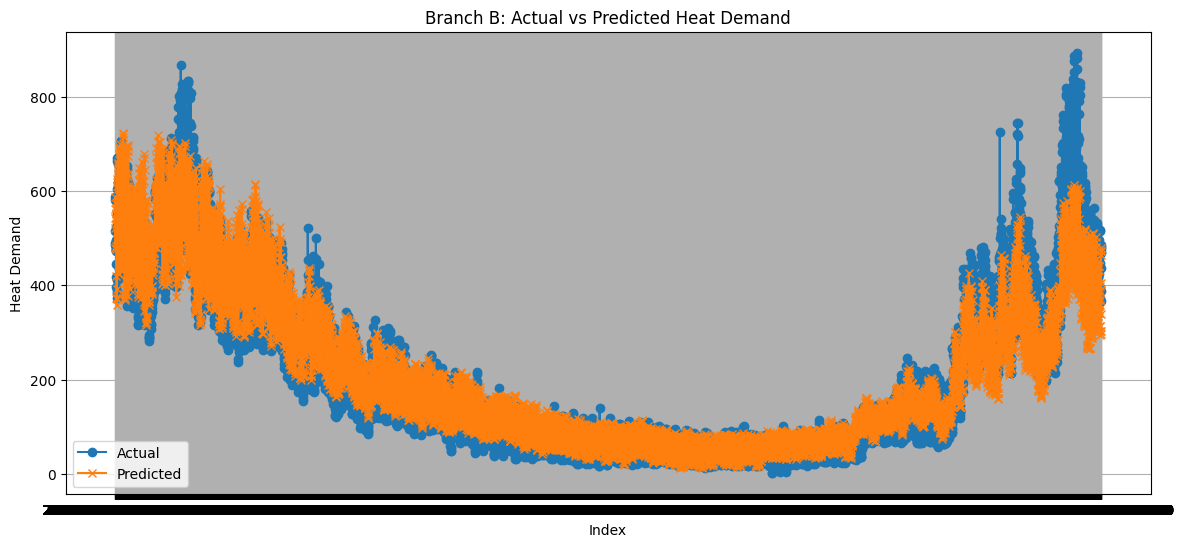

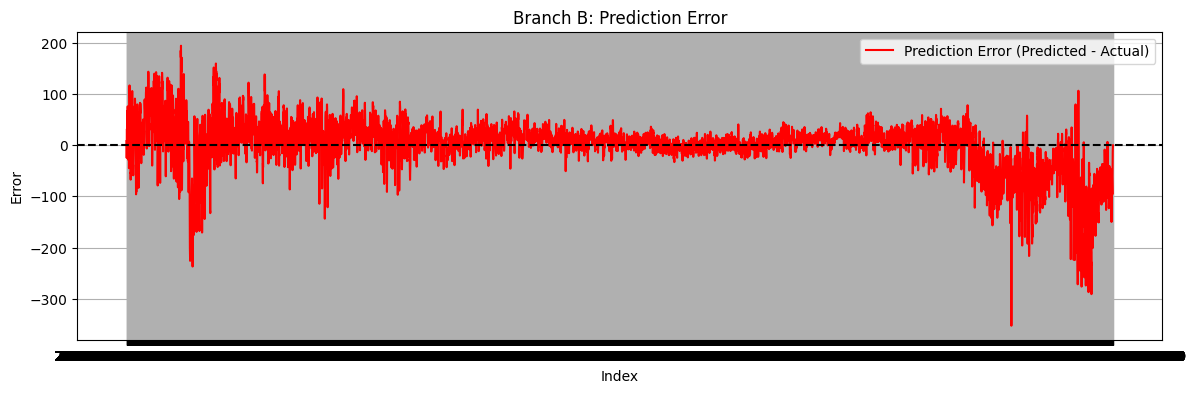

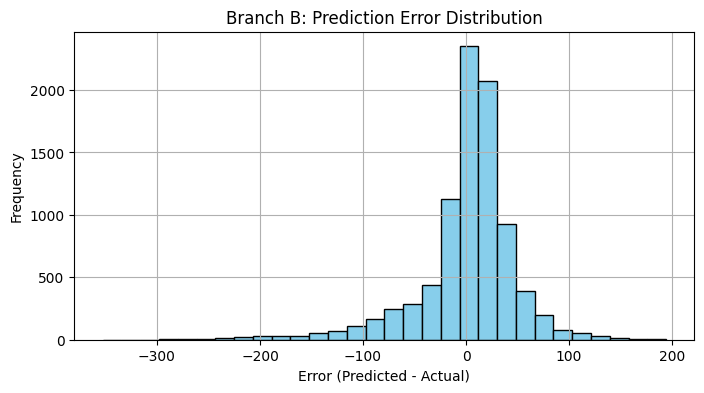

각 Fold의 Validation RMSE: [np.float64(105.28160625312206), np.float64(28.857259570184777)]
최종 평균 Validation RMSE: 67.06943291165342


In [76]:
import numpy as np
import matplotlib.pyplot as plt

# 1. branch_id가 'B'인 데이터만 추출
branch = 'B'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

# branch_id 컬럼 제거 (모델 입력에 불필요)
train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])

target_col = 'heat_demand'

# 2. 예측 수행
results = run_3fold_pipeline_with_residual(train_branch, test_branch, target_col)

# 3. 예측 결과 DataFrame 생성 (index 기준)
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']
}, index=results['test_index'])

# 4. 실제값과 예측값 비교를 위한 df_test_B 준비 (index 기준)
df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

# 5. 공통 인덱스만 사용해서 비교 (NaN 방지)
common_index = df_test_B.index.intersection(test_pred_B.index)
compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']

# 6. NaN이 남아있으면 제거
compare_df = compare_df.dropna()

# 7. RMSE, MAE 계산
rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
mae = np.mean(np.abs(compare_df['diff']))
print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 8. 실제값 vs 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
plt.title('Branch B: Actual vs Predicted Heat Demand')
plt.xlabel('Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid(True)
plt.show()

# 9. 오차 시계열 시각화
plt.figure(figsize=(14, 4))
plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error (Predicted - Actual)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Branch B: Prediction Error')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# 10. 오차 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Branch B: Prediction Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("각 Fold의 Validation RMSE:", results['val_rmses'])
print("최종 평균 Validation RMSE:", results['val_rmse'])


